<a href="https://colab.research.google.com/github/amagyeiantwi-biotech/Glaucoma-Detection-CNN/blob/main/glaucoma_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Total: 2070, Train: 1656, Val: 414
Glaucoma ratio: 24.3%
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

PHASE 1: Training with frozen base
Epoch 1/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.5645 - auc: 0.5008 - loss: 6.0315 - precision: 0.2191 - recall: 0.3893 - val_accuracy: 0.5048 - val_auc: 0.5944 - val_loss: 5.0777 - val_precision: 0.2869 - val_recall: 0.6931 - learning_rate: 0.0010
Epoch 2/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.5529 - auc: 0.5741 - loss: 4.9331 - precision: 0.2798 - recall: 0.5262 - val_accuracy: 0.4783 - val_auc: 0.6515 - val_loss: 4.2733 - val_precision: 0.3038 - val_recall: 0.8812 - learning_rate: 0.0010
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.5880 - auc: 0.5945 - loss: 4.1244 - precision: 0.3088 - recall: 0.5581 - val_accuracy: 0.4130 - val_auc: 0.6293 - val_loss: 3.5822 - val_precision: 0.2848 - val_recall: 0.9307 - learning_rate: 0.0010
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━

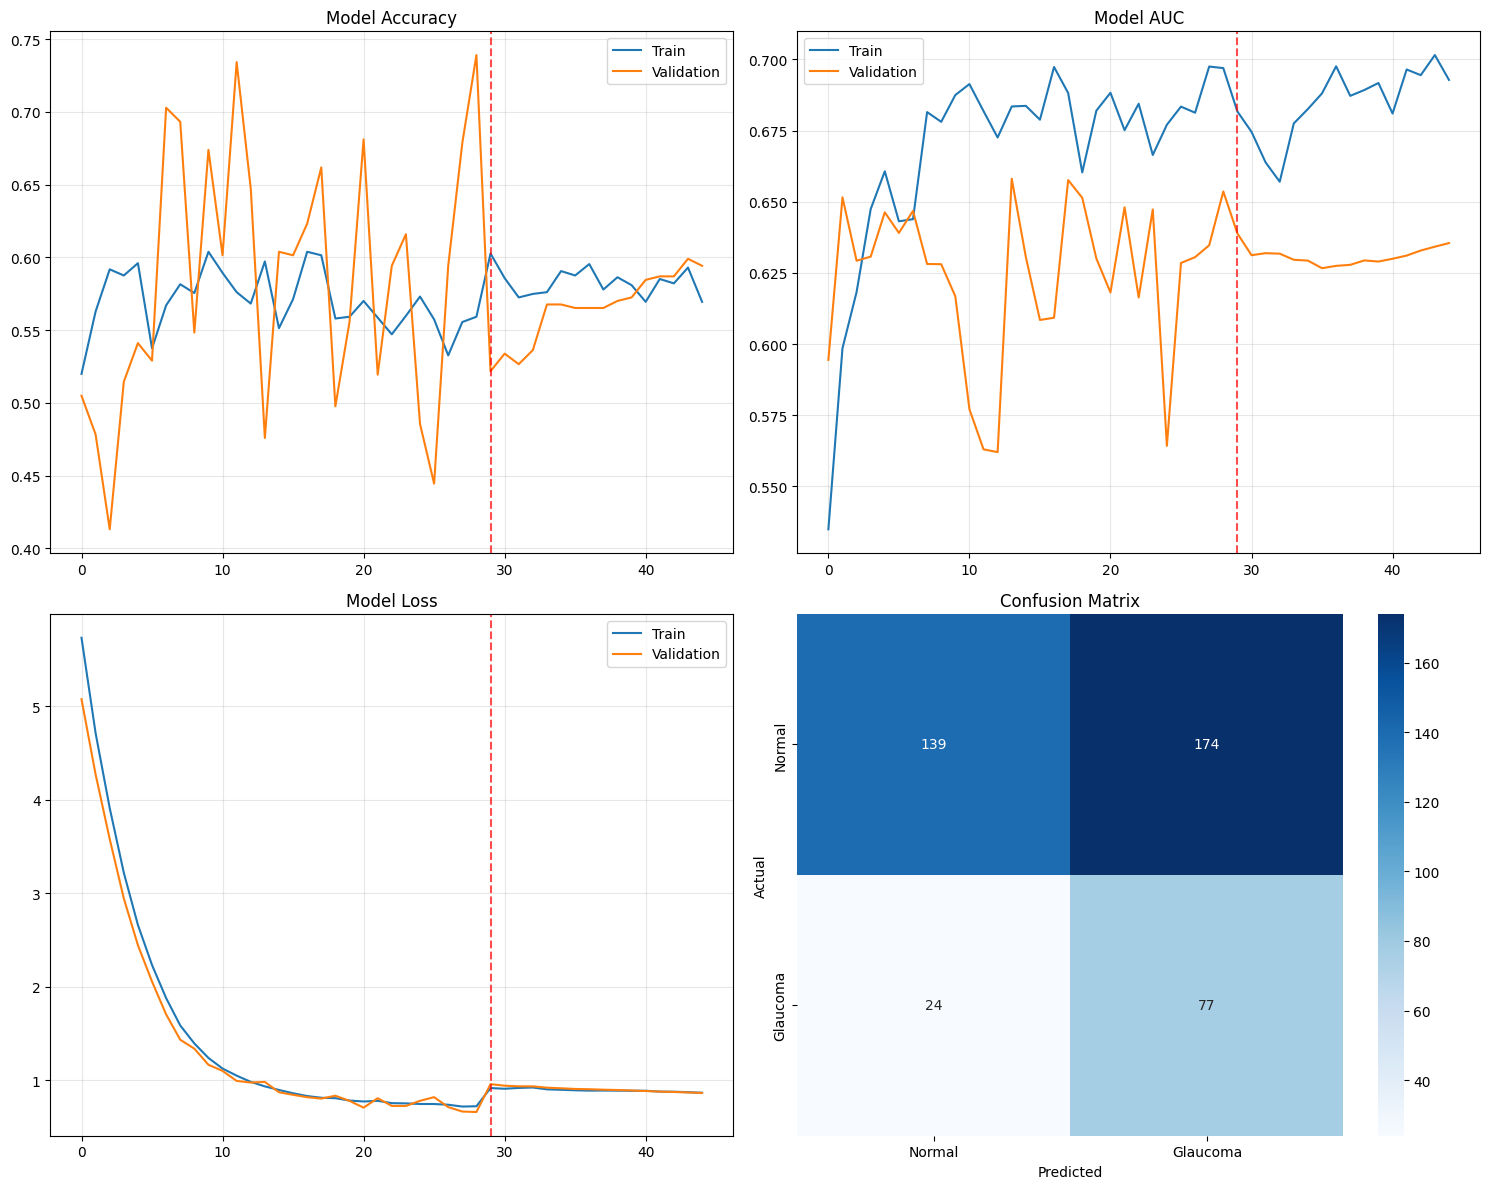

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

tf.keras.backend.clear_session()

from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/Glaucoma REFUGE Dataset.zip'
extract_path = '/content/refuge_data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

BASE_DIR = '/content/refuge_data'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 40
EPOCHS_PHASE2 = 40

def load_all_datasets(base_dir):
    all_paths, all_labels = [], []

    refuge_train = os.path.join(base_dir, 'REFUGE', 'train', 'Images')
    if os.path.exists(refuge_train):
        for img_name in os.listdir(refuge_train):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(refuge_train, img_name)
                all_paths.append(img_path)
                all_labels.append(1 if img_name.lower()[0] == 'g' else 0)

    origa_csv = os.path.join(base_dir, 'ORIGA', 'origa_info.csv')
    if os.path.exists(origa_csv):
        origa_df = pd.read_csv(origa_csv)
        possible_dirs = [
            os.path.join(base_dir, 'ORIGA', 'Images'),
            os.path.join(base_dir, 'ORIGA', 'Images_Square'),
            os.path.join(base_dir, 'ORIGA', 'Images_Cropped'),
        ]

        origa_img_dir = None
        for d in possible_dirs:
            if os.path.exists(d) and len(os.listdir(d)) > 0:
                origa_img_dir = d
                break

        if origa_img_dir:
            origa_files = set(os.listdir(origa_img_dir))
            for _, row in origa_df.iterrows():
                csv_path = str(row['Image'])
                img_basename = os.path.basename(csv_path)
                label = int(row['Label'])

                if img_basename in origa_files:
                    img_path = os.path.join(origa_img_dir, img_basename)
                    all_paths.append(img_path)
                    all_labels.append(label)
                else:
                    name_without_ext = os.path.splitext(img_basename)[0]
                    for ext in ['.jpg', '.png', '.jpeg', '.bmp']:
                        test_name = name_without_ext + ext
                        if test_name in origa_files:
                            img_path = os.path.join(origa_img_dir, test_name)
                            all_paths.append(img_path)
                            all_labels.append(label)
                            break

    g1020_csv = os.path.join(base_dir, 'G1020', 'G1020.csv')
    g1020_img_dir = os.path.join(base_dir, 'G1020', 'Images')
    if os.path.exists(g1020_csv) and os.path.exists(g1020_img_dir):
        g1020_df = pd.read_csv(g1020_csv)
        g1020_files = set(os.listdir(g1020_img_dir))

        for _, row in g1020_df.iterrows():
            img_name = str(row['imageID'])
            label = int(row['binaryLabels'])

            if img_name in g1020_files:
                img_path = os.path.join(g1020_img_dir, img_name)
                all_paths.append(img_path)
                all_labels.append(label)

    return np.array(all_paths), np.array(all_labels)

all_paths, all_labels = load_all_datasets(BASE_DIR)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Total: {len(all_paths)}, Train: {len(train_paths)}, Val: {len(val_paths)}")
print(f"Glaucoma ratio: {sum(all_labels)/len(all_labels)*100:.1f}%")

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    label = tf.cast(label, tf.float32)
    return img, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import regularizers

def build_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model, base_model

model, base_model = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks_phase1 = [
    EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_model_phase1.keras', monitor='val_auc', mode='max', save_best_only=True)
]

print("\nPHASE 1: Training with frozen base")
history_phase1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE1,
                           callbacks=callbacks_phase1, class_weight=class_weight_dict)

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8, verbose=1),
    ModelCheckpoint('best_model_phase2.keras', monitor='val_auc', mode='max', save_best_only=True)
]

print("\nPHASE 2: Fine-tuning")
history_phase2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE2,
                           callbacks=callbacks_phase2, class_weight=class_weight_dict)

results = model.evaluate(val_ds)
val_predictions = model.predict(val_ds)
pred_classes = (val_predictions > 0.5).astype(int).flatten()

cm = confusion_matrix(val_labels, pred_classes)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("\n" + "="*70)
print("FINAL RESULTS:")
print("="*70)
print(f"Validation AUC:       {results[2]:.4f} ({results[2]*100:.2f}%)")
print(f"Validation Accuracy:  {results[1]:.4f} ({results[1]*100:.2f}%)")
print(f"Precision:            {results[3]:.4f}")
print(f"Recall (Sensitivity): {results[4]:.4f}")
print(f"Specificity:          {specificity:.4f}")
print("="*70)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(val_labels, pred_classes, target_names=['Normal', 'Glaucoma']))

model.save('glaucoma_cnn_final.keras')

combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'auc': history_phase1.history['auc'] + history_phase2.history['auc'],
    'val_auc': history_phase1.history['val_auc'] + history_phase2.history['val_auc'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
}

phase1_epochs = len(history_phase1.history['accuracy'])

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(combined_history['accuracy'], label='Train')
axes[0, 0].plot(combined_history['val_accuracy'], label='Validation')
axes[0, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(combined_history['auc'], label='Train')
axes[0, 1].plot(combined_history['val_auc'], label='Validation')
axes[0, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Model AUC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(combined_history['loss'], label='Train')
axes[1, 0].plot(combined_history['val_loss'], label='Validation')
axes[1, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Model Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
axes[1, 1].set_title('Confusion Matrix')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('training_results.png', dpi=300)
plt.show()